# TPSC and the Mermin-Wagner theorem

$$ \chi_{sp}(k, i\omega_n) \equiv \frac{\chi_0(k, i\omega_n)}{1 - \frac{U_{sp}}{2} \chi_0(k, i\omega_n)} $$

$$ \chi_{ch}(k, i\omega_n) \equiv \frac{\chi_0(k, i\omega_n)}{1 + \frac{U_{ch}}{2} \chi_0(k, i\omega_n)} $$

$$ \mathrm{Tr} [ \chi ] \equiv \frac{1}{\beta N_k} \sum_{n, k} \chi(k, i\omega_n) $$


Temperature sweep for $U=4$

Spin structure factor 

$$S(k) \equiv \sum_n \chi_{sp}(i\omega_n, k)$$

In [1]:
from pytriqs.plot.mpl_interface import plt
import numpy as np
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import MeshBrillouinZone, MeshImFreq, Gf, MeshProduct, Idx, inverse
from pytriqs.archive import HDFArchive
from scipy.optimize import fsolve

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%reload_ext cpp2py.magic

In [3]:
%%cpp2py -C pytriqs
#include <triqs/gfs.hpp>
using namespace triqs::gfs;

// The type of a Green function : (k,omega) -> Complex number
using g_k_w_type = gf_view<cartesian_product<brillouin_zone, imfreq>, scalar_valued>;
using g_r_t_type = gf<cartesian_product<cyclic_lattice, imtime>, scalar_valued>;

g_k_w_type bubble(g_k_w_type g0) {
    
    // Fourier Transformation of k, \omega to obtain g(r,t)
    auto grt = make_gf_from_fourier<0,1>(g0);
    
    // The mesh of gtr is a cartesian product mt x mr. We decompose it.
    auto [mr, mt] = grt.mesh();
    
    // The inverse temperature from the mesh
    double beta = mt.domain().beta;
    
    // A new mesh for chi, with a bosonic statistics, but same size as mt.
    auto mtb = gf_mesh<imtime>{beta, Boson, mt.size()};
    
    // Build chi (r, tau) with this new mesh.
    auto chi0 = g_r_t_type{{mr, mtb}};

    // we fill chi : chi(tau, r) = g(beta - tau, -r) * g(tau, r)
    for (auto const &r : mr)      
        for (auto const &t : mtb) 
            chi0[r, t] = grt(-r, beta - t) * grt(r, t); 

    // Fourier transform back to k, \omega space and return
    return make_gf_from_fourier<0,1>(chi0);
}

## Fixed parameters

In [4]:
U = 4.0
t = 1.0
n_k = 32
n_w = 128

# Two unit vectors in R3
BL = BravaisLattice([(1, 0, 0), (0, 1, 0)])
BZ = BrillouinZone(BL)
kmesh = MeshBrillouinZone(BZ, n_k = n_k)

## Functions (were obtained in previous notebooks)

In [7]:
def eps(kx,ky):
    return -2 * t* (np.cos(kx) + np.cos(ky))

def get_chi0(beta):
    
    # Init g0
    wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_w)
    w = np.tensordot(np.ones(n_k*n_k), list(wmesh.values()), 0)
    k = np.tensordot(list(kmesh.values()), np.ones(2*n_w), 0)
    kx, ky = k[:,0,:], k[:,1,:]

    g0 = Gf(mesh = MeshProduct(kmesh, wmesh), target_shape = [])
    g0.data[:,:] = 1 / (w - eps(kx,ky))
    
    return bubble(g0)

def chi_rpa(chi0_wk, U):
    chi_rpa = chi0_kw.copy()
    chi_rpa = chi0_kw * inverse(1 - U * chi0_kw)
    return chi_rpa

# Should we have some kind of trace in TRIQS?
def trace_chi_kw(chi_kw):
    kmesh, wmesh = chi_kw.mesh.components
    # tail correction FIXME!!!
    # We neglect the tail. It is justified at those temperatures
    trace = chi_kw.data.sum() / len(kmesh) / wmesh.beta
    assert(np.abs(trace.imag) < 1e-10)
    return trace.real

def Usp_root_problem(Usp, chi0, n, U):
    tr_chi_sp = trace_chi_kw(chi_rpa(chi0, U=Usp[0]))
    diff = 2*tr_chi_sp + 0.5 * Usp/U * n**2 - n
    return diff

def Uch_root_problem(Uch, chi0, n, U, docc):
    tr_chi_ch = trace_chi_kw(chi_rpa(chi0, U=-Uch[0]))
    diff = 2*tr_chi_ch - 2 * docc - n + n**2
    return diff

def solve_Usp_and_Uch(chi0, U, n, Usp0=0.1, Uch0=0.1):
    Usp = fsolve(Usp_root_problem, Usp0, args=(chi0, n, U), xtol=1e-2)[0]
    docc = 0.25 * Usp / U * n**2
    Uch = fsolve(Uch_root_problem, Uch0, args=(chi0, n, U, docc), xtol=1e-2)[0]
    return Usp, Uch, docc

## RPA

In [8]:
T_rpa_vec = np.concatenate((np.arange(10., 3., -1.), np.arange(3., 0.75, -0.2)))
S_rpa_vec = np.zeros_like(T_rpa_vec)

print ''.join('| %-11s' % s for s in ['T', 'beta', 'S_rpa']), '|'
print '-'*41

for idx, T in enumerate(T_rpa_vec):

    beta = 1. / T
    chi0_kw = get_chi0(beta)
    chi = chi_rpa(chi0_kw, U)
    
    S_rpa = chi[Idx(n_k/2, n_k/2, 0), :].data.sum().real # FIXME: Replace with .density() call
    S_rpa_vec[idx] = S_rpa
    
    print ''.join('| %4.4E ' % x for x in [T, beta, S_rpa]), '|'

| T          | beta       | S_rpa       |
-----------------------------------------
| 1.0000E+01 | 1.0000E-01 | 2.8003E-02  |
| 9.0000E+00 | 1.1111E-01 | 3.1555E-02  |
| 8.0000E+00 | 1.2500E-01 | 3.6140E-02  |
| 7.0000E+00 | 1.4286E-01 | 4.2284E-02  |
| 6.0000E+00 | 1.6667E-01 | 5.0941E-02  |
| 5.0000E+00 | 2.0000E-01 | 6.4021E-02  |
| 4.0000E+00 | 2.5000E-01 | 8.5955E-02  |
| 3.0000E+00 | 3.3333E-01 | 1.2957E-01  |
| 2.8000E+00 | 3.5714E-01 | 1.4385E-01  |
| 2.6000E+00 | 3.8462E-01 | 1.6143E-01  |
| 2.4000E+00 | 4.1667E-01 | 1.8352E-01  |
| 2.2000E+00 | 4.5455E-01 | 2.1200E-01  |
| 2.0000E+00 | 5.0000E-01 | 2.4986E-01  |
| 1.8000E+00 | 5.5556E-01 | 3.0229E-01  |
| 1.6000E+00 | 6.2500E-01 | 3.7898E-01  |
| 1.4000E+00 | 7.1429E-01 | 5.0059E-01  |
| 1.2000E+00 | 8.3333E-01 | 7.2115E-01  |
| 1.0000E+00 | 1.0000E+00 | 1.2504E+00  |
| 8.0000E-01 | 1.2500E+00 | 4.9648E+00  |


## TPSC

In [9]:
n = 1.
Usp, Uch = 1., 1. # initial guess

T_tpsc_vec = np.array([10., 9., 8., 7., 6., 5., 4., 3., 
                       2.5, 2.0, 1.5, 1.2, 1.0, 
                       0.8, 0.6, 0.4, 0.35, 0.3, 0.25])
S_tpsc_vec = np.zeros_like(T_tpsc_vec)
U_sp_vec = np.zeros_like(T_tpsc_vec)

print ''.join('| %-11s' % s for s in ['T', 'beta', 'Usp', 'Uch', 'docc', 'S_tpsc']), '|'
print '-'*80

for idx, T in enumerate(T_tpsc_vec):

    beta = 1. / T    
    chi0_kw = get_chi0(beta) 
    
    Usp, Uch, docc = solve_Usp_and_Uch(chi0_kw, U, n, Usp0=Usp, Uch0=Uch)
    
    chi_sp_wk = chi_rpa(chi0_kw, Usp)
    S_tpsc = chi_sp_wk[Idx(n_k/2, n_k/2, 0),:].data.sum().real

    S_tpsc_vec[idx], U_sp_vec[idx] = S_tpsc, Usp

    print ''.join('| %4.4E ' % x for x in [T, beta, Usp, Uch, docc, S_tpsc]), '|'


| T          | beta       | Usp        | Uch        | docc       | S_tpsc      |
--------------------------------------------------------------------------------
| 1.0000E+01 | 1.0000E-01 | 3.6088E+00 | 4.3954E+00 | 2.2555E-01 | 2.7707E-02  |
| 9.0000E+00 | 1.1111E-01 | 3.5676E+00 | 4.4370E+00 | 2.2298E-01 | 3.1142E-02  |
| 8.0000E+00 | 1.2500E-01 | 3.5170E+00 | 4.4907E+00 | 2.1981E-01 | 3.5541E-02  |
| 7.0000E+00 | 1.4286E-01 | 3.4534E+00 | 4.5593E+00 | 2.1584E-01 | 4.1371E-02  |
| 6.0000E+00 | 1.6667E-01 | 3.3716E+00 | 4.6503E+00 | 2.1073E-01 | 4.9450E-02  |
| 5.0000E+00 | 2.0000E-01 | 3.2634E+00 | 4.7770E+00 | 2.0396E-01 | 6.1355E-02  |
| 4.0000E+00 | 2.5000E-01 | 3.1155E+00 | 4.9669E+00 | 1.9472E-01 | 8.0516E-02  |
| 3.0000E+00 | 3.3333E-01 | 2.9074E+00 | 5.2894E+00 | 1.8171E-01 | 1.1590E-01  |
| 2.5000E+00 | 4.0000E-01 | 2.7731E+00 | 5.5590E+00 | 1.7332E-01 | 1.4725E-01  |
| 2.0000E+00 | 5.0000E-01 | 2.6166E+00 | 5.9903E+00 | 1.6354E-01 | 1.9914E-01  |
| 1.5000E+00 | 6.6667E-01 | 

## Plots results

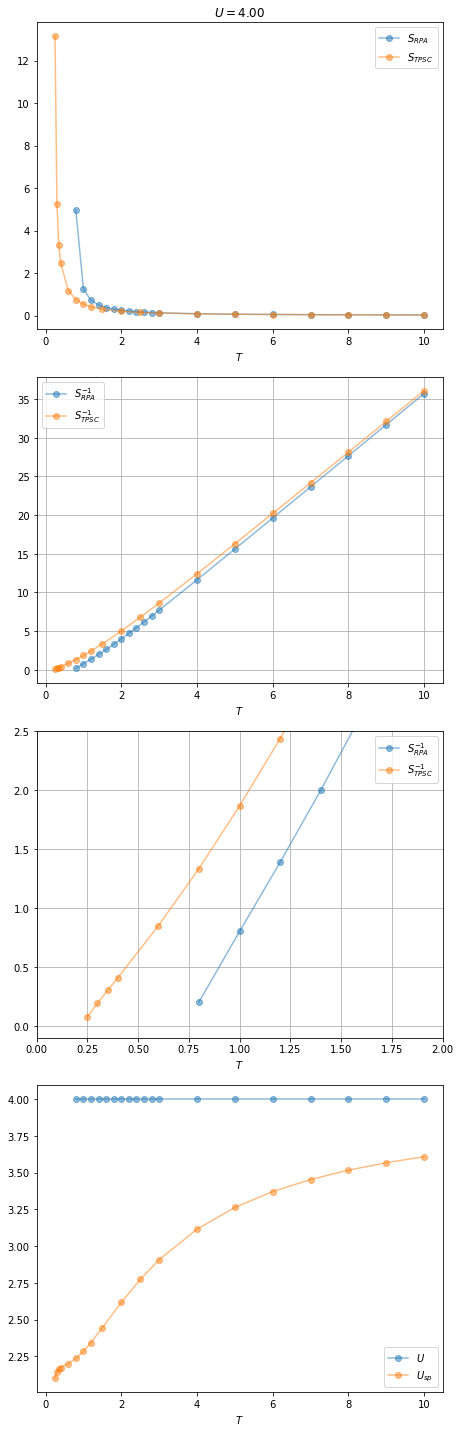

In [10]:
plt.figure(figsize=(3.25*2, 5*4))
subp = [4, 1, 1]

plt.subplot(*subp); subp[-1] += 1
plt.title(r'$U = %2.2f$' % U)
plt.plot(T_rpa_vec, S_rpa_vec, 'o-', label=r'$S_{RPA}$', alpha=0.5)
plt.plot(T_tpsc_vec, S_tpsc_vec, 'o-', label=r'$S_{TPSC}$', alpha=0.5)
plt.legend(loc='best')
plt.xlabel(r'$T$')

plt.subplot(*subp); subp[-1] += 1
plt.plot(T_rpa_vec, 1./S_rpa_vec, 'o-', alpha=0.5, label=r'$S_{RPA}^{-1}$')
plt.plot(T_tpsc_vec, 1./S_tpsc_vec, 'o-', alpha=0.5, label=r'$S_{TPSC}^{-1}$')
plt.legend(loc='best')
plt.xlabel(r'$T$'); plt.grid()

plt.subplot(*subp); subp[-1] += 1
plt.plot(T_rpa_vec, 1./S_rpa_vec, 'o-', alpha=0.5, label=r'$S_{RPA}^{-1}$')
plt.plot(T_tpsc_vec, 1./S_tpsc_vec, 'o-', alpha=0.5, label=r'$S_{TPSC}^{-1}$')
plt.legend(loc='best'); plt.xlim([0, 2]); plt.ylim([-0.1, 2.5])
plt.xlabel(r'$T$'); plt.grid()

plt.subplot(*subp); subp[-1] += 1
plt.plot(T_rpa_vec, U + 0*T_rpa_vec, 'o-', alpha=0.5, label=r'$U$')
plt.plot(T_tpsc_vec, U_sp_vec, 'o-', alpha=0.5, label=r'$U_{sp}$')
plt.legend(loc='best')
plt.xlabel(r'$T$')

plt.tight_layout()
plt.savefig('figure_S_TPSC_RPA_vs_T.pdf')